## NeurIPS Results Parser

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-05-13 22:03:06.214052: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 22:03:07.595332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 22:03:09.259102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib as npm

  au

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn
absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn


<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 0.0%
RAM Usage: 2.9%
Available RAM: 977.6G
Total RAM: 1007.0G
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 0


In [6]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()

# if a number is seen a GPU is available
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

XGBoost version: 2.0.3
cupy version: 13.1.0


ValueError: invalid literal for int() with base 10: 'No devices were found'

In [7]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Parse UKBB final run results

True

In [8]:
# Get all csv files in results folder
results_dir = './notebooks/NeurIPS/results/UKBB_true'
results_files = []
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith('.csv') and 'results' in file.lower():
            results_files.append(os.path.join(root, file))

# Load each results file into a dataframe
transformer_df = pd.read_csv(os.path.join(results_dir, 'transformer_singlerun_results.csv'))
mlp_pls_df = pd.read_csv(os.path.join(results_dir, 'MLP_PLS_CV_results.csv'))
bilinear_pca_df = pd.read_csv(os.path.join(results_dir, 'bilinear_PCA_CV_results.csv'))
transformer_cls_df = pd.read_csv(os.path.join(results_dir, 'transformer_CLS_4head.csv'))# 'transformer_CLS_singlerun_results.csv'))
mlp_pca_df = pd.read_csv(os.path.join(results_dir, 'MLP_PCA_CV_results.csv'))
bilinear_lowrank_df = pd.read_csv(os.path.join(results_dir, 'bilinear_lowrank_CV_results.csv'))
mlp_df = pd.read_csv(os.path.join(results_dir, 'MLP_CV_results.csv'))
mlp_cls_df = pd.read_csv(os.path.join(results_dir, 'MLP_transcriptome_euclidean_CV_results.csv'))
bilinear_pls_df = pd.read_csv(os.path.join(results_dir, 'bilinear_PLS_CV_results.csv'))

In [ ]:
metrics_list = [
    'final_test_metrics.pearson_r',
    'final_test_metrics.r2',
    'final_test_metrics.mse',
    'final_test_metrics.geodesic_distance',
    'final_test_metrics.short_r',
    'final_test_metrics.mid_r',
    'final_test_metrics.long_r',
    'final_train_metrics.pearson_r',
    'final_train_metrics.r2',
    'final_train_metrics.mse',
    'final_train_metrics.geodesic_distance',
    'final_train_metrics.short_r',
    'final_train_metrics.mid_r',
    'final_train_metrics.long_r'
]

# Subset each dataframe to only include the metrics columns
dfs = {
    'transformer_df': transformer_df[metrics_list],
    'mlp_cls_df': mlp_cls_df[metrics_list],
    'mlp_pls_df': mlp_pls_df[metrics_list],
    'bilinear_pca_df': bilinear_pca_df[metrics_list],
    'transformer_cls_df': transformer_cls_df[metrics_list],
    'mlp_pca_df': mlp_pca_df[metrics_list], 
    'bilinear_lowrank_df': bilinear_lowrank_df[metrics_list],
    'mlp_df': mlp_df[metrics_list],
    'bilinear_pls_df': bilinear_pls_df[metrics_list]
}

# Print any missing columns that couldn't be included
for df_name, df in dfs.items():
    missing_cols = [col for col in metrics_list if col not in df.columns]
    if missing_cols:
        print(f"\nMissing columns in {df_name}:")
        for col in missing_cols:
            print(f"  - {col}")


# Print the first few rows of each dataframe and check for NaN values
for df_name, df in dfs.items():
    print(f"\nHead of {df_name}:")
    print(df.head())
    print(f"\nNaN values in {df_name}:")
    print(df.isna().sum())
    print("-" * 80)


# Create a DataFrame to store results
results = pd.DataFrame(index=metrics_list)

# For each model type
for model_name, df in dfs.items():
    # Calculate mean and std for each metric
    mean_col = f"{model_name}_mean"
    std_col = f"{model_name}_std"
    
    # Compute statistics for each metric
    for metric in metrics_list:
        if metric in df.columns:
            mean_val = df[metric].mean()
            std_val = df[metric].std()
            results.loc[metric, mean_col] = mean_val
            results.loc[metric, std_col] = std_val
        else:
            results.loc[metric, mean_col] = np.nan
            results.loc[metric, std_col] = np.nan

# Display results
print("\nMean and standard deviation for each metric across models:")
print(results)





Head of transformer_df:
   final_test_metrics.pearson_r  final_test_metrics.r2  \
0                      0.847029               0.715918   
1                      0.842610               0.705390   
2                      0.831612               0.687694   
3                      0.826214               0.681986   
4                      0.823987               0.674524   

   final_test_metrics.mse  final_test_metrics.geodesic_distance  \
0                0.010897                              9.932060   
1                0.010778                              8.714811   
2                0.012087                              9.922932   
3                0.011846                             10.505120   
4                0.011402                             10.323794   

   final_test_metrics.short_r  final_test_metrics.mid_r  \
0                    0.869464                  0.808334   
1                    0.868142                  0.810349   
2                    0.855749                 

In [10]:
# GLOBAL 

# Define mapping from df names to display names
model_name_mapping = {
    'bilinear_pca_df': 'Bilinear CM (PCA)',
    'bilinear_pls_df': 'Bilinear CM (PLS)', 
    'bilinear_lowrank_df': 'Low-Rank Bilinear',
    'mlp_pca_df': 'MLP (PCA)',
    'mlp_pls_df': 'MLP (PLS)',
    'mlp_df': 'MLP',
    'mlp_cls_df': 'MLP w/ coords',
    'transformer_df': 'SMT',
    'transformer_cls_df': 'SMT w/ CLS'
}


In [11]:
# Combine mean and std dev for test metrics only
formatted_results = pd.DataFrame()
test_metrics = [m for m in metrics_list if m.startswith('final_test_metrics')]

# Define mapping from df names to display names
model_name_mapping = {
    'bilinear_pca_df': 'Bilinear CM (PCA)',
    'bilinear_pls_df': 'Bilinear CM (PLS)', 
    'bilinear_lowrank_df': 'Low-Rank Bilinear',
    'mlp_pca_df': 'MLP (PCA)',
    'mlp_pls_df': 'MLP (PLS)',
    'mlp_df': 'MLP',
    'mlp_cls_df': 'MLP w/ coords',
    'transformer_df': 'SMT',
    'transformer_cls_df': 'SMT w/ CLS'
}

# Define column name mapping
metric_name_mapping = {
    'pearson_r': 'Pearson-r',
    'r2': 'R²',
    'mse': 'MSE',
    'geodesic_distance': 'Geodesic Distance',
    'short_r': 'Short-range r',
    'mid_r': 'Mid-range r', 
    'long_r': 'Long-range r'
}

for metric in test_metrics:
    means = results.loc[metric].filter(like='mean')
    stds = results.loc[metric].filter(like='std')
    
    # Create combined strings of mean ± std
    combined = []
    for m, s in zip(means, stds):
        metric_name = metric.replace('final_test_metrics.', '')
        if metric_name == 'mse':
            mean_val = round(float(m), 3)  # Keep MSE at 3 decimal places
        else:
            mean_val = round(float(m), 2)  # Other metrics at 2 decimal places
        std_val = float(s)
        # Round std to 2 decimal places if possible (if >= 0.01)
        if std_val >= 0.01:
            std_val = round(std_val, 2)
        else:
            std_val = round(std_val, 3)
        combined.append(f"{mean_val} ± {std_val}")
    
    # Create new row with combined values
    model_names = [name.replace('_mean','') for name in means.index]
    # Remove 'final_test_metrics.' prefix and map to formatted name
    metric_name = metric.replace('final_test_metrics.', '')
    metric_name = metric_name_mapping.get(metric_name, metric_name)
    formatted_results[metric_name] = pd.Series(combined, index=model_names)

# Define the desired order of models
model_order = [
    'bilinear_pca_df',
    'bilinear_pls_df',
    'bilinear_lowrank_df',
    'mlp_pca_df', 
    'mlp_pls_df',
    'mlp_df',
    'mlp_cls_df',
    'transformer_df',
    'transformer_cls_df'
]

# Reindex the DataFrame according to the specified order and map index names
formatted_results = formatted_results.reindex(model_order)
formatted_results.index = [model_name_mapping[model] for model in model_order]

# Display the sorted results
formatted_results

,Pearson-r,R²,MSE,Geodesic Distance,Short-range r,Mid-range r,Long-range r
Bilinear CM (PCA),0.5 ± 0.04,0.23 ± 0.04,0.026 ± 0.002,16.08 ± 1.69,0.55 ± 0.05,0.42 ± 0.04,0.33 ± 0.07
Bilinear CM (PLS),0.39 ± 0.09,-1.89 ± 6.23,0.096 ± 0.21,19.2 ± 4.88,0.43 ± 0.1,0.32 ± 0.08,0.27 ± 0.08
Low-Rank Bilinear,0.77 ± 0.04,0.59 ± 0.06,0.014 ± 0.002,11.17 ± 0.68,0.79 ± 0.03,0.74 ± 0.04,0.69 ± 0.07
MLP (PCA),0.75 ± 0.03,0.55 ± 0.06,0.015 ± 0.002,12.51 ± 1.02,0.79 ± 0.03,0.71 ± 0.04,0.61 ± 0.09
MLP (PLS),0.75 ± 0.05,0.56 ± 0.09,0.015 ± 0.003,12.78 ± 0.92,0.78 ± 0.05,0.72 ± 0.06,0.69 ± 0.07
MLP,0.78 ± 0.03,0.59 ± 0.06,0.014 ± 0.002,10.78 ± 1.23,0.81 ± 0.03,0.75 ± 0.04,0.67 ± 0.06
MLP w/ coords,0.81 ± 0.03,0.65 ± 0.05,0.012 ± 0.001,10.62 ± 1.1,0.83 ± 0.03,0.78 ± 0.04,0.73 ± 0.06
SMT,0.79 ± 0.03,0.61 ± 0.05,0.013 ± 0.001,10.87 ± 1.1,0.82 ± 0.03,0.76 ± 0.03,0.68 ± 0.06
SMT w/ CLS,0.82 ± 0.03,0.66 ± 0.05,0.011 ± 0.002,9.88 ± 0.64,0.84 ± 0.03,0.79 ± 0.03,0.76 ± 0.06


In [12]:

# Convert formatted_results to LaTeX table and find best/second best values
latex_table = """\\begin{table}
  \\caption{Performance comparison of different models on gene expression to connectivity prediction}
  \\label{tab:model-comparison}
  \\centering
  \\small
  \\begin{tabular}{lccccccc}
    \\toprule
    Model & Pearson-r & R² & MSE & Geodesic Distance & Short-range r & Mid-range r & Long-range r \\\\
    \\midrule"""

# Helper function to extract numeric value from formatted string
def extract_value(s):
    return float(s.split(' ±')[0])

# Find best and second best values for each column
best_values = {}
second_best_values = {}
for col in formatted_results.columns:
    values = [extract_value(v) for v in formatted_results[col]]
    if col == 'MSE' or col == 'Geodesic Distance':
        # For these metrics, lower is better
        best_values[col] = min(values)
        second_best_values[col] = sorted(values)[1]
    else:
        # For other metrics, higher is better
        best_values[col] = max(values)
        second_best_values[col] = sorted(values, reverse=True)[1]

# Add each row
for model in formatted_results.index:
    row = [model]
    for col in formatted_results.columns:
        value = formatted_results.loc[model, col]
        numeric_val = extract_value(value)
        if numeric_val == best_values[col]:
            value = "\\textbf{" + value + "}"
        elif numeric_val == second_best_values[col]:
            value = "\\textit{" + value + "}"
        row.append(value)
    latex_table += "\n    " + " & ".join(row) + " \\\\"

latex_table += """
    \\bottomrule
  \\end{tabular}
\\end{table}"""

print(latex_table)

\begin{table}
  \caption{Performance comparison of different models on gene expression to connectivity prediction}
  \label{tab:model-comparison}
  \centering
  \small
  \begin{tabular}{lccccccc}
    \toprule
    Model & Pearson-r & R² & MSE & Geodesic Distance & Short-range r & Mid-range r & Long-range r \\
    \midrule
    Bilinear CM (PCA) & 0.5 ± 0.04 & 0.23 ± 0.04 & 0.026 ± 0.002 & 16.08 ± 1.69 & 0.55 ± 0.05 & 0.42 ± 0.04 & 0.33 ± 0.07 \\
    Bilinear CM (PLS) & 0.39 ± 0.09 & -1.89 ± 6.23 & 0.096 ± 0.21 & 19.2 ± 4.88 & 0.43 ± 0.1 & 0.32 ± 0.08 & 0.27 ± 0.08 \\
    Low-Rank Bilinear & 0.77 ± 0.04 & 0.59 ± 0.06 & 0.014 ± 0.002 & 11.17 ± 0.68 & 0.79 ± 0.03 & 0.74 ± 0.04 & 0.69 ± 0.07 \\
    MLP (PCA) & 0.75 ± 0.03 & 0.55 ± 0.06 & 0.015 ± 0.002 & 12.51 ± 1.02 & 0.79 ± 0.03 & 0.71 ± 0.04 & 0.61 ± 0.09 \\
    MLP (PLS) & 0.75 ± 0.05 & 0.56 ± 0.09 & 0.015 ± 0.003 & 12.78 ± 0.92 & 0.78 ± 0.05 & 0.72 ± 0.06 & 0.69 ± 0.07 \\
    MLP & 0.78 ± 0.03 & 0.59 ± 0.06 & 0.014 ± 0.002 & 10.78 ± 1.23

Null

In [13]:
# Get all csv files in results folder
results_dir = './notebooks/NeurIPS/results/UKBB_null'
results_files = []
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith('.csv'):
            results_files.append(os.path.join(root, file))

print(results_files)

# Load each results file into a dataframe
transformer_df = pd.read_csv(f'{results_dir}/transformer_null.csv')
mlp_cls_df = pd.read_csv(f'{results_dir}/MLP_cls_null.csv')
mlp_pls_df = pd.read_csv(f'{results_dir}/MLP_PLS_null.csv')
bilinear_pca_df = pd.read_csv(f'{results_dir}/bilinear_PCA_null.csv')
transformer_cls_df = pd.read_csv(f'{results_dir}/transformer_CLS_null_4head.csv')
mlp_pca_df = pd.read_csv(f'{results_dir}/MLP_PCA_null.csv')
bilinear_lowrank_df = pd.read_csv(f'{results_dir}/bilinear_lowrank_null.csv')
mlp_df = pd.read_csv(f'{results_dir}/MLP_null.csv')
bilinear_pls_df = pd.read_csv(f'{results_dir}/bilinear_PLS_null.csv')

['./notebooks/NeurIPS/results/UKBB_null/transformer_CLS_null_4head.csv', './notebooks/NeurIPS/results/UKBB_null/bilinear_PCA_null.csv', './notebooks/NeurIPS/results/UKBB_null/bilinear_PLS_null.csv', './notebooks/NeurIPS/results/UKBB_null/MLP_PLS_null.csv', './notebooks/NeurIPS/results/UKBB_null/MLP_null.csv', './notebooks/NeurIPS/results/UKBB_null/bilinear_lowrank_null.csv', './notebooks/NeurIPS/results/UKBB_null/MLP_cls_null.csv', './notebooks/NeurIPS/results/UKBB_null/transformer_null.csv', './notebooks/NeurIPS/results/UKBB_null/MLP_PCA_null.csv', './notebooks/NeurIPS/results/UKBB_null/transformer_CLS_null.csv']


In [14]:
# Subset each dataframe to only include the metrics columns
dfs = {
    'transformer_df': transformer_df[metrics_list],
    'mlp_pls_df': mlp_pls_df[metrics_list],
    'mlp_cls_df': mlp_cls_df[metrics_list],
    'bilinear_pca_df': bilinear_pca_df[metrics_list],
    'transformer_cls_df': transformer_cls_df[metrics_list],
    'mlp_pca_df': mlp_pca_df[metrics_list], 
    'bilinear_lowrank_df': bilinear_lowrank_df[metrics_list],
    'mlp_df': mlp_df[metrics_list],
    'bilinear_pls_df': bilinear_pls_df[metrics_list]
}

# Print any missing columns that couldn't be included
for df_name, df in dfs.items():
    missing_cols = [col for col in metrics_list if col not in df.columns]
    if missing_cols:
        print(f"\nMissing columns in {df_name}:")
        for col in missing_cols:
            print(f"  - {col}")


# Print the first few rows of each dataframe and check for NaN values
for df_name, df in dfs.items():
    print(f"\nHead of {df_name}:")
    print(df.head())
    print(f"\nNaN values in {df_name}:")
    print(df.isna().sum())
    print("-" * 80)


# Create a DataFrame to store results
results = pd.DataFrame(index=metrics_list)

# For each model type
for model_name, df in dfs.items():
    # Calculate mean and std for each metric
    mean_col = f"{model_name}_mean"
    std_col = f"{model_name}_std"
    
    # Compute statistics for each metric
    for metric in metrics_list:
        if metric in df.columns:
            mean_val = df[metric].mean()
            std_val = df[metric].std()
            results.loc[metric, mean_col] = mean_val
            results.loc[metric, std_col] = std_val
        else:
            results.loc[metric, mean_col] = np.nan
            results.loc[metric, std_col] = np.nan

# Display results
print("\nMean and standard deviation for each metric across models:")
print(results)



Head of transformer_df:
   final_test_metrics.pearson_r  final_test_metrics.r2  \
0                      0.541124               0.211401   
1                      0.463915               0.159516   
2                      0.388625              -0.070739   
3                      0.425932               0.077043   
4                      0.326737              -0.132401   

   final_test_metrics.mse  final_test_metrics.geodesic_distance  \
0                0.028849                             14.199189   
1                0.029335                             15.776731   
2                0.031351                             15.918628   
3                0.031948                             15.342939   
4                0.034943                             17.362362   

   final_test_metrics.short_r  final_test_metrics.mid_r  \
0                    0.533169                  0.472186   
1                    0.450972                  0.419660   
2                    0.374148                 

In [16]:
# Combine mean and std dev for test metrics only
formatted_results = pd.DataFrame()
test_metrics = [m for m in metrics_list if m.startswith('final_test_metrics')]

# Define column name mapping
metric_name_mapping = {
    'pearson_r': 'Pearson-r',
    'r2': 'R²',
    'mse': 'MSE',
    'geodesic_distance': 'Geodesic Distance',
    'short_r': 'Short-range r',
    'mid_r': 'Mid-range r', 
    'long_r': 'Long-range r'
}

for metric in test_metrics:
    means = results.loc[metric].filter(like='mean')
    stds = results.loc[metric].filter(like='std')
    
    # Create combined strings of mean ± std
    combined = []
    for m, s in zip(means, stds):
        metric_name = metric.replace('final_test_metrics.', '')
        if metric_name == 'mse':
            mean_val = round(float(m), 3)  # Keep MSE at 3 decimal places
        else:
            mean_val = round(float(m), 2)  # Other metrics at 2 decimal places
        std_val = float(s)
        # Round std to 2 decimal places if possible (if >= 0.01)
        if std_val >= 0.01:
            std_val = round(std_val, 2)
        else:
            std_val = round(std_val, 3)
        combined.append(f"{mean_val} ± {std_val}")
    
    # Create new row with combined values
    model_names = [name.replace('_mean','') for name in means.index]
    # Remove 'final_test_metrics.' prefix and map to formatted name
    metric_name = metric.replace('final_test_metrics.', '')
    metric_name = metric_name_mapping.get(metric_name, metric_name)
    formatted_results[metric_name] = pd.Series(combined, index=model_names)

# Define the desired order of models
model_order = [
    'bilinear_pca_df',
    'bilinear_pls_df',
    'bilinear_lowrank_df',
    'mlp_pca_df', 
    'mlp_pls_df',
    'mlp_df',
    'mlp_cls_df',
    'transformer_df',
    'transformer_cls_df'
]

# Reindex the DataFrame according to the specified order and map index names
formatted_results = formatted_results.reindex(model_order)
formatted_results.index = [model_name_mapping[model] for model in model_order]

# Display the sorted results
formatted_results

,Pearson-r,R²,MSE,Geodesic Distance,Short-range r,Mid-range r,Long-range r
Bilinear CM (PCA),0.29 ± 0.07,0.07 ± 0.05,0.031 ± 0.003,20.74 ± 3.8,0.31 ± 0.08,0.2 ± 0.07,0.23 ± 0.07
Bilinear CM (PLS),0.27 ± 0.08,-4.87 ± 25.03,0.208 ± 0.92,20.46 ± 4.22,0.28 ± 0.08,0.2 ± 0.07,0.2 ± 0.08
Low-Rank Bilinear,0.42 ± 0.08,0.16 ± 0.08,0.028 ± 0.004,16.84 ± 1.66,0.42 ± 0.08,0.35 ± 0.08,0.34 ± 0.12
MLP (PCA),0.41 ± 0.07,0.13 ± 0.08,0.029 ± 0.004,18.08 ± 1.34,0.41 ± 0.07,0.34 ± 0.07,0.33 ± 0.09
MLP (PLS),0.39 ± 0.07,0.14 ± 0.08,0.029 ± 0.003,19.49 ± 1.5,0.38 ± 0.07,0.33 ± 0.07,0.31 ± 0.1
MLP,0.3 ± 0.08,-0.22 ± 0.15,0.041 ± 0.006,15.23 ± 1.08,0.31 ± 0.08,0.24 ± 0.08,0.23 ± 0.1
MLP w/ coords,0.47 ± 0.08,0.11 ± 0.13,0.03 ± 0.005,14.31 ± 1.2,0.48 ± 0.08,0.39 ± 0.08,0.36 ± 0.11
SMT,0.33 ± 0.09,-0.08 ± 0.12,0.037 ± 0.005,16.45 ± 1.37,0.33 ± 0.09,0.28 ± 0.09,0.27 ± 0.12
SMT w/ CLS,0.71 ± 0.05,0.47 ± 0.09,0.018 ± 0.003,11.52 ± 0.84,0.73 ± 0.05,0.67 ± 0.05,0.65 ± 0.08


In [17]:
# Convert formatted_results to LaTeX table and find best/second best values
latex_table = """\\begin{table}
  \\caption{Performance comparison of different models on gene expression to connectivity prediction}
  \\label{tab:model-comparison}
  \\centering
  \\small
  \\begin{tabular}{lccccccc}
    \\toprule
    Model & Pearson-r & R² & MSE & Geodesic Distance & Short-range r & Mid-range r & Long-range r \\\\
    \\midrule"""

# Helper function to extract numeric value from formatted string
def extract_value(s):
    return float(s.split(' ±')[0])

# Find best and second best values for each column
best_values = {}
second_best_values = {}
for col in formatted_results.columns:
    values = [extract_value(v) for v in formatted_results[col]]
    if col == 'MSE' or col == 'Geodesic Distance':
        # For these metrics, lower is better
        best_values[col] = min(values)
        second_best_values[col] = sorted(values)[1]
    else:
        # For other metrics, higher is better
        best_values[col] = max(values)
        second_best_values[col] = sorted(values, reverse=True)[1]

# Add each row
for model in formatted_results.index:
    row = [model + " \\textit{(null)}"]  # Add (null) in italics after model name
    for col in formatted_results.columns:
        value = formatted_results.loc[model, col]
        numeric_val = extract_value(value)
        if numeric_val == best_values[col]:
            value = "\\textbf{" + value + "}"
        elif numeric_val == second_best_values[col]:
            value = "\\textit{" + value + "}"
        row.append(value)
    latex_table += "\n    " + " & ".join(row) + " \\\\"

latex_table += """
    \\bottomrule
  \\end{tabular}
\\end{table}"""

print(latex_table)

\begin{table}
  \caption{Performance comparison of different models on gene expression to connectivity prediction}
  \label{tab:model-comparison}
  \centering
  \small
  \begin{tabular}{lccccccc}
    \toprule
    Model & Pearson-r & R² & MSE & Geodesic Distance & Short-range r & Mid-range r & Long-range r \\
    \midrule
    Bilinear CM (PCA) \textit{(null)} & 0.29 ± 0.07 & 0.07 ± 0.05 & 0.031 ± 0.003 & 20.74 ± 3.8 & 0.31 ± 0.08 & 0.2 ± 0.07 & 0.23 ± 0.07 \\
    Bilinear CM (PLS) \textit{(null)} & 0.27 ± 0.08 & -4.87 ± 25.03 & 0.208 ± 0.92 & 20.46 ± 4.22 & 0.28 ± 0.08 & 0.2 ± 0.07 & 0.2 ± 0.08 \\
    Low-Rank Bilinear \textit{(null)} & 0.42 ± 0.08 & \textit{0.16 ± 0.08} & \textit{0.028 ± 0.004} & 16.84 ± 1.66 & 0.42 ± 0.08 & 0.35 ± 0.08 & 0.34 ± 0.12 \\
    MLP (PCA) \textit{(null)} & 0.41 ± 0.07 & 0.13 ± 0.08 & 0.029 ± 0.004 & 18.08 ± 1.34 & 0.41 ± 0.07 & 0.34 ± 0.07 & 0.33 ± 0.09 \\
    MLP (PLS) \textit{(null)} & 0.39 ± 0.07 & 0.14 ± 0.08 & 0.029 ± 0.003 & 19.49 ± 1.5 & 0.38 ± 0.07 

### Ablation experiment

In [18]:
# Get all csv files in results folder
results_dir = './notebooks/NeurIPS/results/ablation/'
results_files = []
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith('.csv'):
            results_files.append(os.path.join(root, file))

print(results_files)

# Create a dictionary to store DataFrames
ablation_dfs = {}

# Load each CSV file and store in dictionary with descriptive name
ablation_dfs['cls_no_slope'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_CLS_no_slope.csv')
ablation_dfs['cls_no_slope_no_aug'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_CLS_no_slope_no_aug.csv')
ablation_dfs['no_slope_no_cls'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_noslope_nocls.csv')
ablation_dfs['no_slope_no_aug_no_cls'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_noslope_noaug_nocls.csv')
ablation_dfs['no_cls'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_noCLS.csv')
ablation_dfs['full_model'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_CLS_all.csv')

# Print info about each DataFrame
for name, df in ablation_dfs.items():
    print(f"\n{name}:")
    print(df.info())


['./notebooks/NeurIPS/results/ablation/transformer_CLS_no_slope.csv', './notebooks/NeurIPS/results/ablation/transformer_CLS_no_slope_no_aug.csv', './notebooks/NeurIPS/results/ablation/transformer_noslope_nocls.csv', './notebooks/NeurIPS/results/ablation/transformer_noslope_noaug_nocls.csv', './notebooks/NeurIPS/results/ablation/transformer_noCLS.csv', './notebooks/NeurIPS/results/ablation/transformer_CLS_all.csv']

cls_no_slope:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   40 non-null     object 
 1   final_test_metrics.pearson_r           40 non-null     float64
 2   Commit                                 40 non-null     object 
 3   Created                                40 non-null     object 
 4   Runtime                                40 non-null 

In [19]:
ablation_latex_no_std = """\\begin{table}[h]
  \\caption{Ablation Study Results}
  \\label{tab:ablation}
  \\begin{tabular}{lccccccc}
    \\toprule
    Model & Pearson-r & R² & MSE & Geodesic & Short-r & Mid-r & Long-r \\\\
    \\midrule"""

# Define model name mapping
model_name_map = {
    'no_slope_no_aug_no_cls': 'Base SMT',
    'no_slope_no_cls': 'Base SMT + Target Aug',
    'no_cls': 'Base SMT + Target Aug + Slope',
    'cls_no_slope_no_aug': 'SMT w/ CLS',
    'cls_no_slope': 'SMT w/ CLS + Target Aug',
    'full_model': 'SMT w/ CLS + Target Aug + Slope'
}

# Define order of models
model_order = [
    'no_slope_no_aug_no_cls',
    'no_slope_no_cls', 
    'no_cls',
    'cls_no_slope_no_aug',
    'cls_no_slope',
    'full_model'
]

# Add each row without std dev
for model_key in model_order:
    df = ablation_dfs[model_key]
    row = [model_name_map[model_key]]
    
    # Add metrics without std dev
    row.append(str(round(df['final_test_metrics.pearson_r'].mean(), 2)))
    row.append(str(round(df['final_test_metrics.r2'].mean(), 2)))
    row.append(str(round(df['final_test_metrics.mse'].mean(), 3)))
    row.append(str(round(df['final_test_metrics.geodesic_distance'].mean(), 2)))
    row.append(str(round(df['final_test_metrics.short_r'].mean(), 2)))
    row.append(str(round(df['final_test_metrics.mid_r'].mean(), 2)))
    row.append(str(round(df['final_test_metrics.long_r'].mean(), 2)))
    
    ablation_latex_no_std += "\n    " + " & ".join(row) + " \\\\"

ablation_latex_no_std += """
    \\bottomrule
  \\end{tabular}
\\end{table}"""

print(ablation_latex_no_std)


\begin{table}[h]
  \caption{Ablation Study Results}
  \label{tab:ablation}
  \begin{tabular}{lccccccc}
    \toprule
    Model & Pearson-r & R² & MSE & Geodesic & Short-r & Mid-r & Long-r \\
    \midrule
    Base SMT & 0.77 & 0.58 & 0.014 & 10.6 & 0.81 & 0.74 & 0.67 \\
    Base SMT + Target Aug & 0.78 & 0.59 & 0.014 & 10.66 & 0.81 & 0.74 & 0.66 \\
    Base SMT + Target Aug + Slope & 0.78 & 0.6 & 0.013 & 10.59 & 0.81 & 0.75 & 0.67 \\
    SMT w/ CLS & 0.81 & 0.64 & 0.012 & 10.68 & 0.83 & 0.78 & 0.78 \\
    SMT w/ CLS + Target Aug & 0.81 & 0.63 & 0.012 & 10.57 & 0.83 & 0.78 & 0.78 \\
    SMT w/ CLS + Target Aug + Slope & 0.82 & 0.66 & 0.011 & 9.88 & 0.84 & 0.79 & 0.76 \\
    \bottomrule
  \end{tabular}
\end{table}


In [20]:
ablation_latex_no_std = """\\begin{table}[h]
  \\caption{Ablation Study Results}
  \\label{tab:ablation}
  \\begin{tabular}{lccccccc}
    \\toprule
    Model & Pearson-r & R² & MSE & Geodesic & Short-r & Mid-r & Long-r \\\\
    \\midrule"""

# Define model name mapping
model_name_map = {
    'no_slope_no_aug_no_cls': 'Base SMT',
    'no_slope_no_cls': 'Base SMT + Target Aug',
    'no_cls': 'Base SMT + Target Aug + Slope',
    'cls_no_slope_no_aug': 'SMT w/ CLS',
    'cls_no_slope': 'SMT w/ CLS + Target Aug',
    'full_model': 'SMT w/ CLS + Target Aug + Slope'
}

# Define order of models
model_order = [
    'no_slope_no_aug_no_cls',
    'no_slope_no_cls', 
    'no_cls',
    'cls_no_slope_no_aug',
    'cls_no_slope',
    'full_model'
]

# Add each row with std dev
for model_key in model_order:
    df = ablation_dfs[model_key]
    row = [model_name_map[model_key]]
    
    # Add metrics with std dev
    row.append(f"{df['final_test_metrics.pearson_r'].mean():.3f} ± {df['final_test_metrics.pearson_r'].std():.3f}")
    row.append(f"{df['final_test_metrics.r2'].mean():.3f} ± {df['final_test_metrics.r2'].std():.3f}")
    row.append(f"{df['final_test_metrics.mse'].mean():.4f} ± {df['final_test_metrics.mse'].std():.4f}")
    row.append(f"{df['final_test_metrics.geodesic_distance'].mean():.3f} ± {df['final_test_metrics.geodesic_distance'].std():.3f}")
    row.append(f"{df['final_test_metrics.short_r'].mean():.3f} ± {df['final_test_metrics.short_r'].std():.3f}")
    row.append(f"{df['final_test_metrics.mid_r'].mean():.3f} ± {df['final_test_metrics.mid_r'].std():.3f}")
    row.append(f"{df['final_test_metrics.long_r'].mean():.3f} ± {df['final_test_metrics.long_r'].std():.3f}")
    
    ablation_latex_no_std += "\n    " + " & ".join(row) + " \\\\"

ablation_latex_no_std += """
    \\bottomrule
  \\end{tabular}
\\end{table}"""

print(ablation_latex_no_std)


\begin{table}[h]
  \caption{Ablation Study Results}
  \label{tab:ablation}
  \begin{tabular}{lccccccc}
    \toprule
    Model & Pearson-r & R² & MSE & Geodesic & Short-r & Mid-r & Long-r \\
    \midrule
    Base SMT & 0.773 ± 0.033 & 0.582 ± 0.071 & 0.0139 ± 0.0019 & 10.596 ± 0.749 & 0.805 ± 0.029 & 0.740 ± 0.042 & 0.666 ± 0.080 \\
    Base SMT + Target Aug & 0.776 ± 0.033 & 0.590 ± 0.059 & 0.0136 ± 0.0015 & 10.657 ± 0.737 & 0.806 ± 0.029 & 0.744 ± 0.038 & 0.664 ± 0.077 \\
    Base SMT + Target Aug + Slope & 0.784 ± 0.030 & 0.602 ± 0.055 & 0.0132 ± 0.0014 & 10.586 ± 0.797 & 0.814 ± 0.027 & 0.755 ± 0.035 & 0.672 ± 0.076 \\
    SMT w/ CLS & 0.811 ± 0.041 & 0.638 ± 0.080 & 0.0121 ± 0.0026 & 10.682 ± 1.122 & 0.834 ± 0.042 & 0.776 ± 0.046 & 0.778 ± 0.053 \\
    SMT w/ CLS + Target Aug & 0.812 ± 0.036 & 0.634 ± 0.075 & 0.0122 ± 0.0024 & 10.569 ± 0.895 & 0.835 ± 0.039 & 0.777 ± 0.042 & 0.778 ± 0.052 \\
    SMT w/ CLS + Target Aug + Slope & 0.817 ± 0.028 & 0.659 ± 0.050 & 0.0114 ± 0.0017 & 9.8

<Figure size 3600x1800 with 0 Axes>

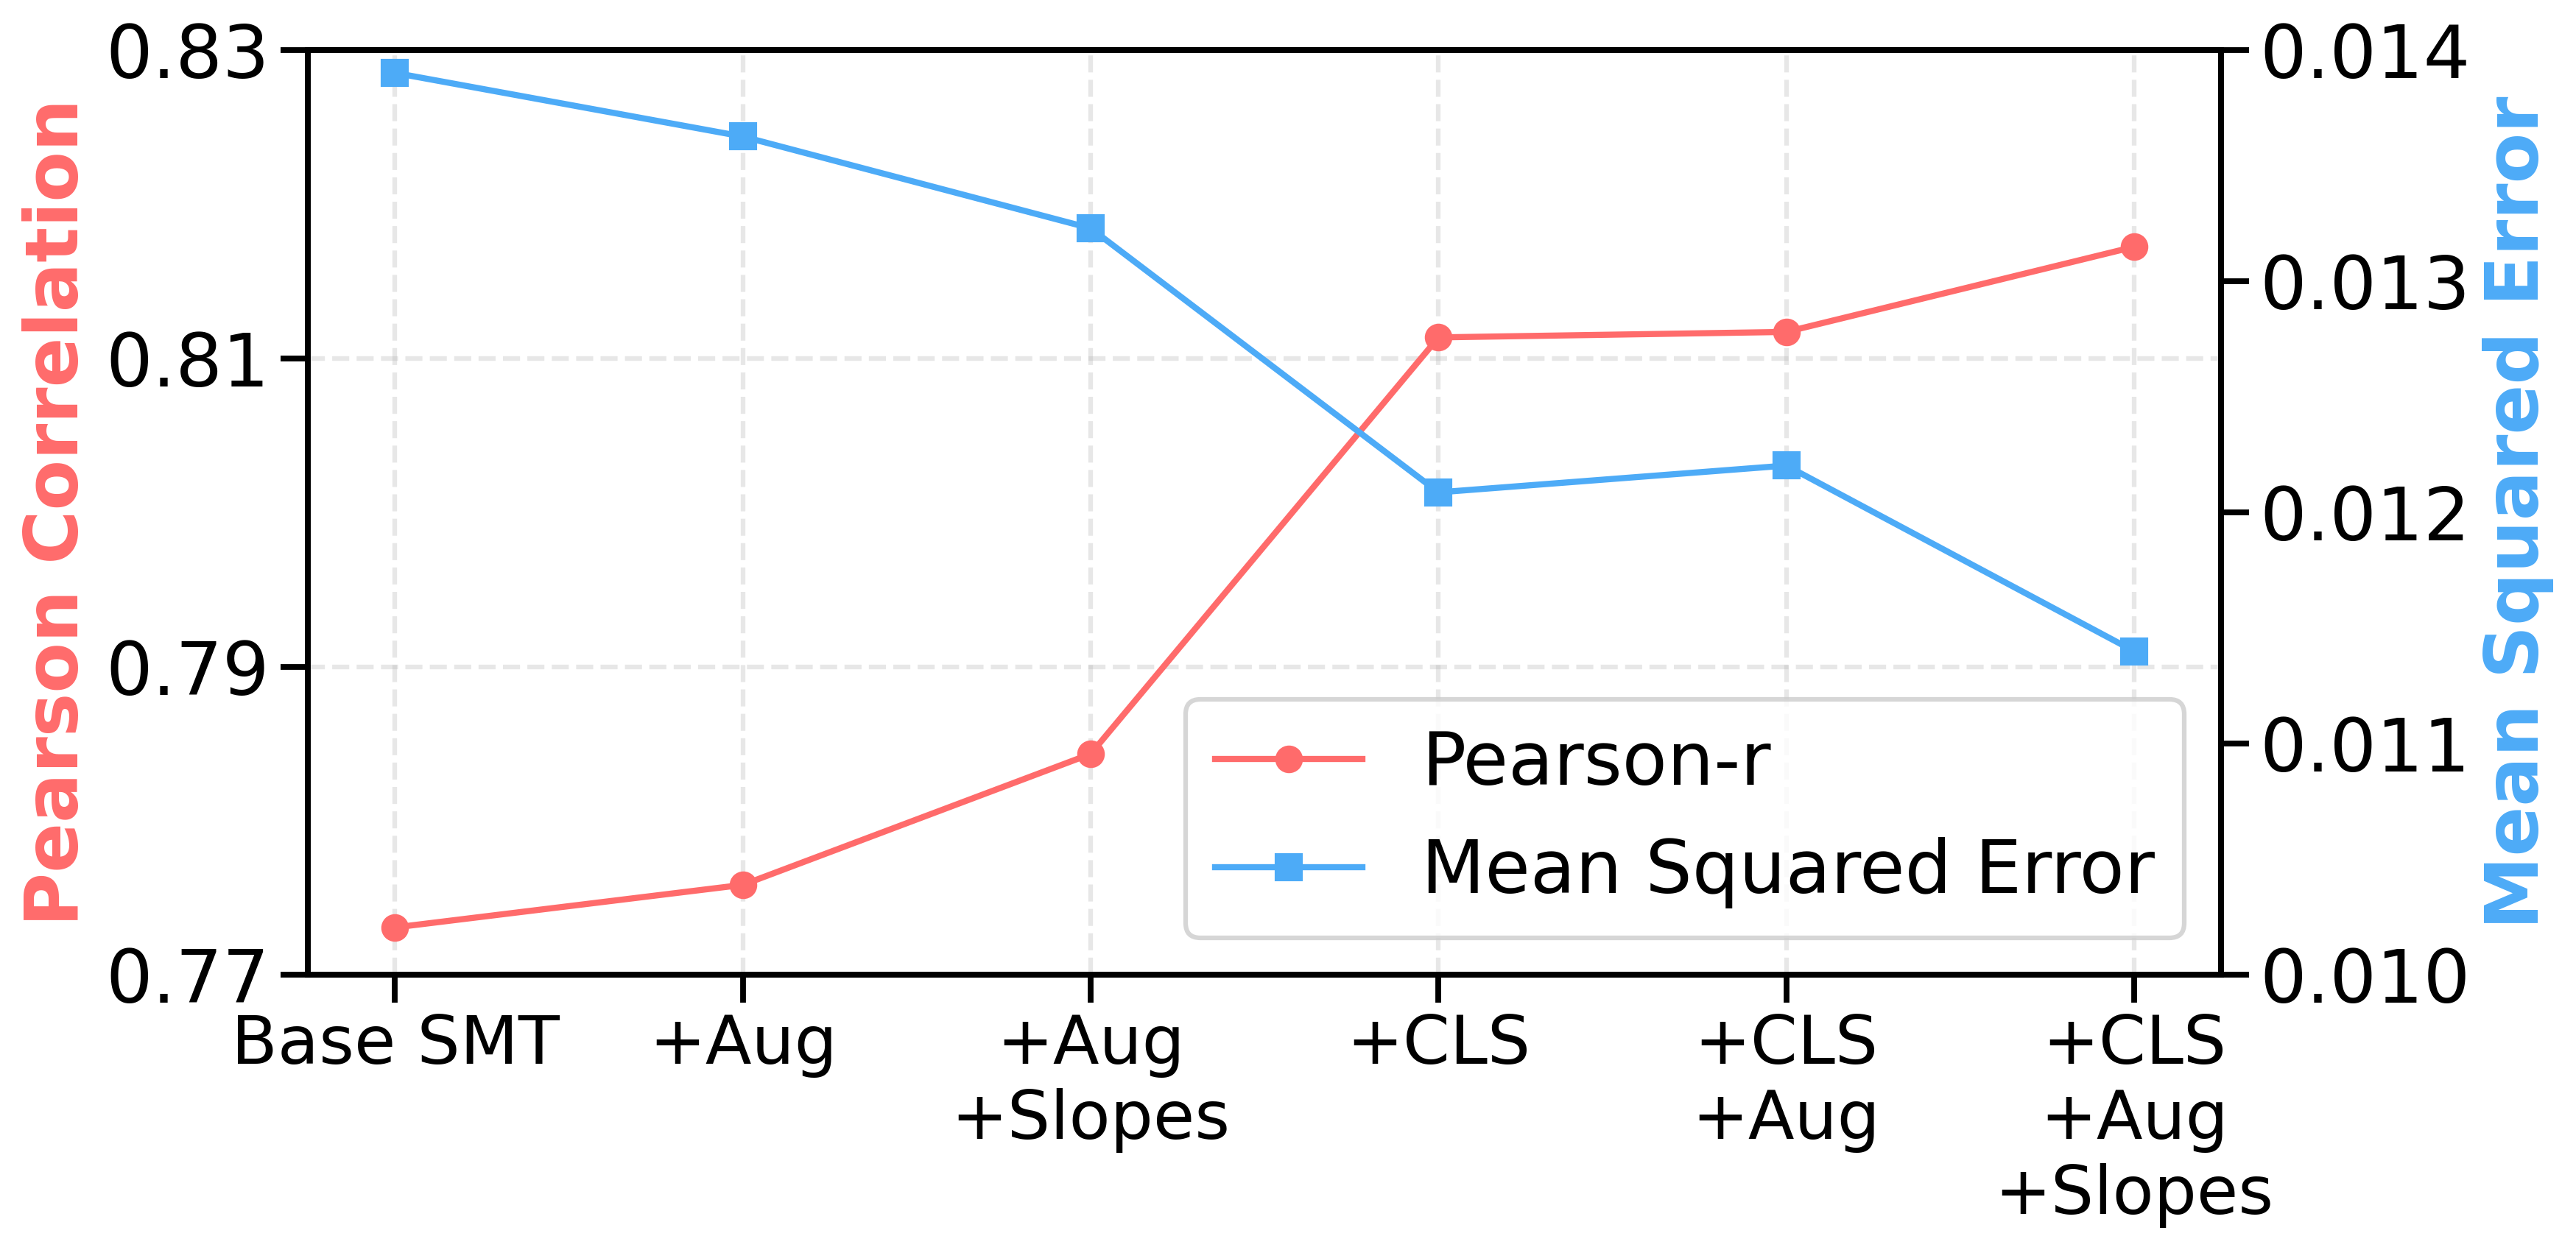

In [47]:
# Create figure showing performance improvements with each feature
FONT_SIZE = 24  # Global font size parameter
plt.figure(figsize=(12, 6), dpi=300)  # Wider figure, higher DPI for publication quality

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)
ax2 = ax1.twinx()

# Get data in order
pearson_scores = []
mse_scores = []
for model in model_order:
    df = ablation_dfs[model]
    pearson_scores.append(df['final_test_metrics.pearson_r'].mean())
    mse_scores.append(df['final_test_metrics.mse'].mean())

# X-axis labels
x_labels = [
    'Base SMT',
    '+Aug', 
    '+Aug\n+Slopes',
    '+CLS',
    '+CLS\n+Aug',
    '+CLS\n+Aug\n+Slopes'
]

x = range(len(x_labels))

# Softer colors
soft_red = '#ff6b6b'
soft_blue = '#4dabf7'

# Plot Pearson correlation (red) on left y-axis
line1 = ax1.plot(x, pearson_scores, color=soft_red, linewidth=2, marker='o', markersize=8, label='Pearson-r')
ax1.set_ylim([0.77, 0.83])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE, fontweight='bold')
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.02))  # Set tick interval to 0.02
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))  # Format to 2 decimal places
ax1.set_yticks(np.arange(0.77, 0.84, 0.02))  # Start at 0.77, go to 0.83 in steps of 0.02
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE)

# Plot MSE (blue) on right y-axis with sparser ticks
line2 = ax2.plot(x, mse_scores, color=soft_blue, linewidth=2, marker='s', markersize=8, label='Mean Squared Error')
ax2.set_ylim([0.010, 0.014])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE, fontweight='bold')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.001))  # Set tick interval to 0.001
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE)

# X-axis formatting
plt.xticks(x, x_labels, rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-2)
plt.xlabel('Model Features', fontsize=FONT_SIZE)
# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

# Add legend
lines1 = line1 + line2
labels = [l.get_label() for l in lines1]
ax1.legend(lines1, labels, loc='lower right', fontsize=FONT_SIZE)

# Adjust layout
plt.tight_layout()
plt.show()


### Parse transformer hyperparameter experiments

In [8]:
token_df = pd.read_csv('./notebooks/quick_experiments/token_size_experiment.csv')
target_aug_df = pd.read_csv('./notebooks/quick_experiments/target_aug_experiment.csv')
cls_df = pd.read_csv('./notebooks/quick_experiments/cls_experiment.csv')
alibi_df = pd.read_csv('./notebooks/quick_experiments/alibi_experiment.csv')


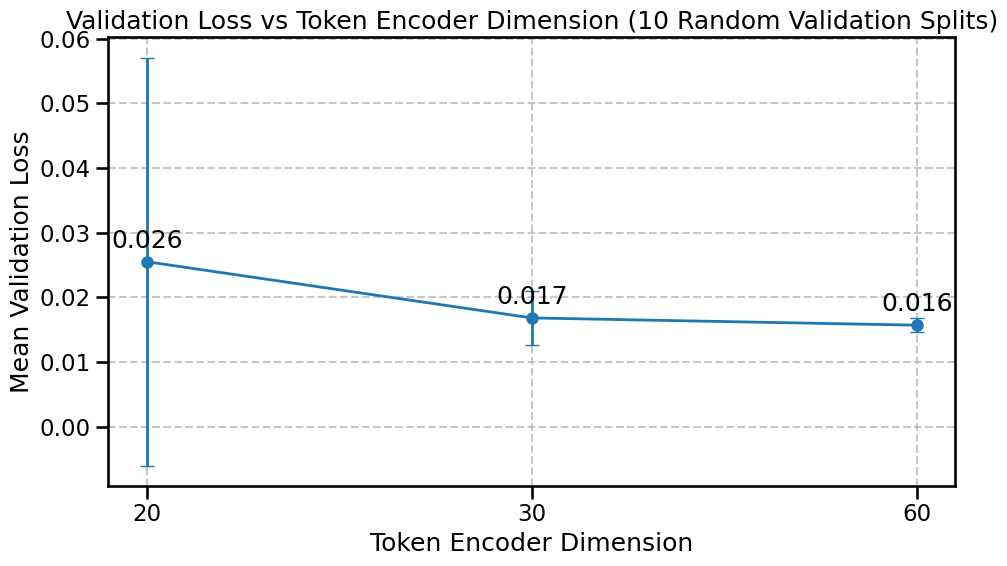

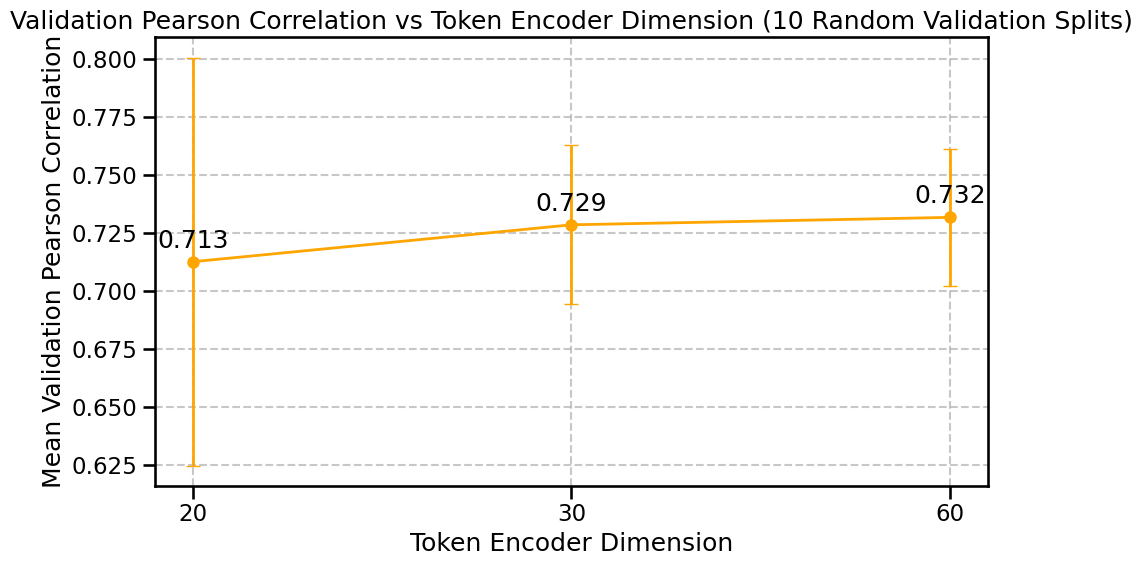

In [9]:
token_df.head(50)
# Drop rows where mean_val_loss is NaN
token_df = token_df.dropna(subset=['mean_val_loss'])
# Sort the dataframe by token_encoder_dim column
token_df = token_df.sort_values(by='token_encoder_dim')

token_df.head(50)

# Group by token_encoder_dim and calculate mean and std of mean_val_loss
token_stats = token_df.groupby('token_encoder_dim')['mean_val_loss'].agg(['mean', 'std']).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(token_stats)), 
            token_stats['mean'], 
            yerr=token_stats['std'],
            fmt='o-',  # Line style with points
            capsize=5,  # Cap width for error bars
            markersize=8,  # Size of points
            linewidth=2)  # Width of line

plt.xlabel('Token Encoder Dimension')
plt.ylabel('Mean Validation Loss')
plt.title('Validation Loss vs Token Encoder Dimension (10 Random Validation Splits)')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-ticks to show token dimensions
plt.xticks(range(len(token_stats)), token_stats['token_encoder_dim'])

# Add points to show exact values
for i, (_, y, std) in enumerate(zip(token_stats['token_encoder_dim'], token_stats['mean'], token_stats['std'])):
    plt.annotate(f'{y:.3f}', 
                (i, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()

# Group by token_encoder_dim and calculate mean and std of mean_val_pearson
token_pearson_stats = token_df.groupby('token_encoder_dim')['mean_val_pearson'].agg(['mean', 'std']).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(token_pearson_stats)), 
            token_pearson_stats['mean'], 
            yerr=token_pearson_stats['std'],
            fmt='o-',  # Line style with points
            capsize=5,  # Cap width for error bars
            markersize=8,  # Size of points
            linewidth=2,
            color='orange')  # Width of line

plt.xlabel('Token Encoder Dimension')
plt.ylabel('Mean Validation Pearson Correlation')
plt.title('Validation Pearson Correlation vs Token Encoder Dimension (10 Random Validation Splits)')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-ticks to show token dimensions
plt.xticks(range(len(token_pearson_stats)), token_pearson_stats['token_encoder_dim'])

# Add points to show exact values
for i, (_, y, std) in enumerate(zip(token_pearson_stats['token_encoder_dim'], token_pearson_stats['mean'], token_pearson_stats['std'])):
    plt.annotate(f'{y:.3f}', 
                (i, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()


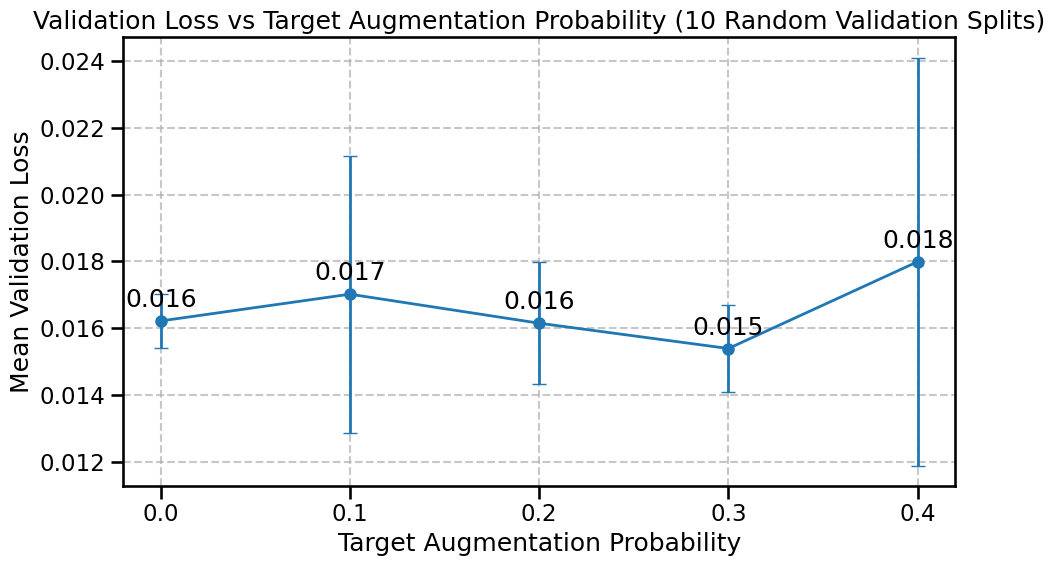

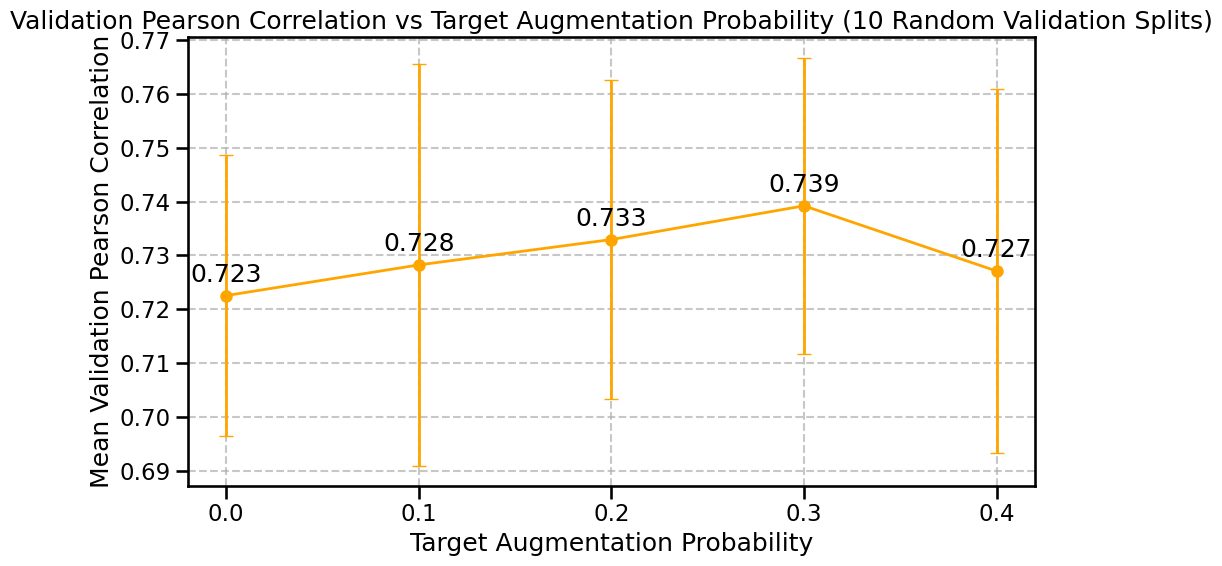

In [10]:
target_aug_df.head(50)
# Drop rows where mean_val_loss is NaN
target_aug_df = target_aug_df.dropna(subset=['mean_val_loss'])
# Sort the dataframe by aug_prob column
target_aug_df = target_aug_df.sort_values(by='aug_prob')

target_aug_df.head(50)

# Group by aug_prob and calculate mean and std of mean_val_loss
aug_stats = target_aug_df.groupby('aug_prob')['mean_val_loss'].agg(['mean', 'std']).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(aug_stats)), 
            aug_stats['mean'], 
            yerr=aug_stats['std'],
            fmt='o-',  # Line style with points
            capsize=5,  # Cap width for error bars
            markersize=8,  # Size of points
            linewidth=2)  # Width of line

plt.xlabel('Target Augmentation Probability')
plt.ylabel('Mean Validation Loss')
plt.title('Validation Loss vs Target Augmentation Probability (10 Random Validation Splits)')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-ticks to show augmentation probabilities
plt.xticks(range(len(aug_stats)), aug_stats['aug_prob'])

# Add points to show exact values
for i, (_, y, std) in enumerate(zip(aug_stats['aug_prob'], aug_stats['mean'], aug_stats['std'])):
    plt.annotate(f'{y:.3f}', 
                (i, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()

# Group by aug_prob and calculate mean and std of mean_val_pearson
aug_pearson_stats = target_aug_df.groupby('aug_prob')['mean_val_pearson'].agg(['mean', 'std']).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(aug_pearson_stats)), 
            aug_pearson_stats['mean'], 
            yerr=aug_pearson_stats['std'],
            fmt='o-',  # Line style with points
            capsize=5,  # Cap width for error bars
            markersize=8,  # Size of points
            linewidth=2,
            color='orange')  # Width of line

plt.xlabel('Target Augmentation Probability')
plt.ylabel('Mean Validation Pearson Correlation')
plt.title('Validation Pearson Correlation vs Target Augmentation Probability (10 Random Validation Splits)')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-ticks to show augmentation probabilities
plt.xticks(range(len(aug_pearson_stats)), aug_pearson_stats['aug_prob'])

# Add points to show exact values
for i, (_, y, std) in enumerate(zip(aug_pearson_stats['aug_prob'], aug_pearson_stats['mean'], aug_pearson_stats['std'])):
    plt.annotate(f'{y:.3f}', 
                (i, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()


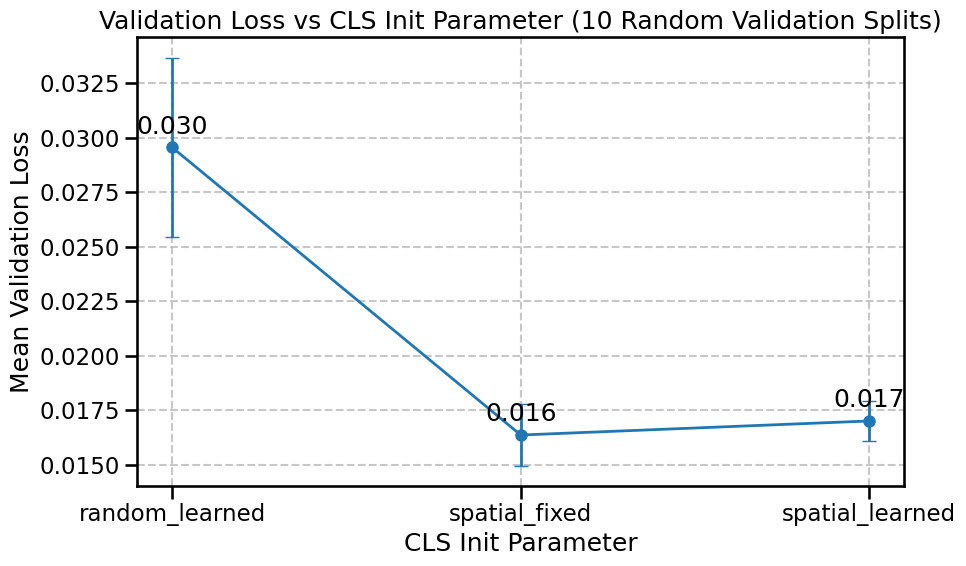

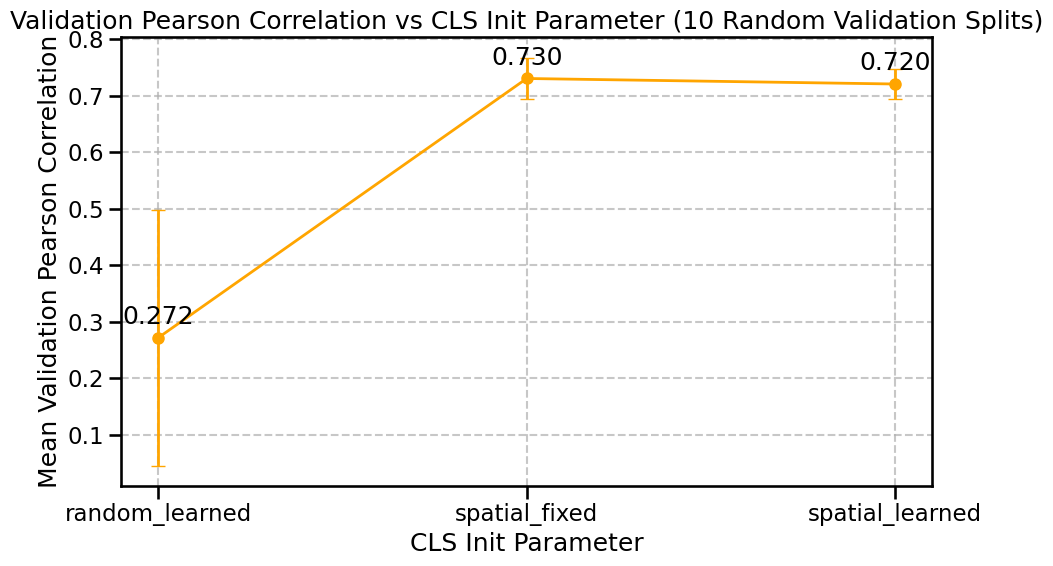

In [11]:
cls_df.head(50)
# Drop rows where mean_val_loss is NaN
cls_df = cls_df.dropna(subset=['mean_val_loss'])
# Sort the dataframe by cls_init column
cls_df = cls_df.sort_values(by='cls_init')

cls_df.head(50)

# Group by cls_init and calculate mean and std of mean_val_loss
cls_stats = cls_df.groupby('cls_init')['mean_val_loss'].agg(['mean', 'std']).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(cls_stats)), 
            cls_stats['mean'], 
            yerr=cls_stats['std'],
            fmt='o-',  # Line style with points
            capsize=5,  # Cap width for error bars
            markersize=8,  # Size of points
            linewidth=2)  # Width of line

plt.xlabel('CLS Init Parameter')
plt.ylabel('Mean Validation Loss')
plt.title('Validation Loss vs CLS Init Parameter (10 Random Validation Splits)')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-ticks to show cls_init values
plt.xticks(range(len(cls_stats)), cls_stats['cls_init'])

# Add points to show exact values
for i, (_, y, std) in enumerate(zip(cls_stats['cls_init'], cls_stats['mean'], cls_stats['std'])):
    plt.annotate(f'{y:.3f}', 
                (i, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()

# Group by cls_init and calculate mean and std of mean_val_pearson
cls_pearson_stats = cls_df.groupby('cls_init')['mean_val_pearson'].agg(['mean', 'std']).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(cls_pearson_stats)), 
            cls_pearson_stats['mean'], 
            yerr=cls_pearson_stats['std'],
            fmt='o-',  # Line style with points
            capsize=5,  # Cap width for error bars
            markersize=8,  # Size of points
            linewidth=2,
            color='orange')  # Width of line

plt.xlabel('CLS Init Parameter')
plt.ylabel('Mean Validation Pearson Correlation')
plt.title('Validation Pearson Correlation vs CLS Init Parameter (10 Random Validation Splits)')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-ticks to show cls_init values
plt.xticks(range(len(cls_pearson_stats)), cls_pearson_stats['cls_init'])

# Add points to show exact values
for i, (_, y, std) in enumerate(zip(cls_pearson_stats['cls_init'], cls_pearson_stats['mean'], cls_pearson_stats['std'])):
    plt.annotate(f'{y:.3f}', 
                (i, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()


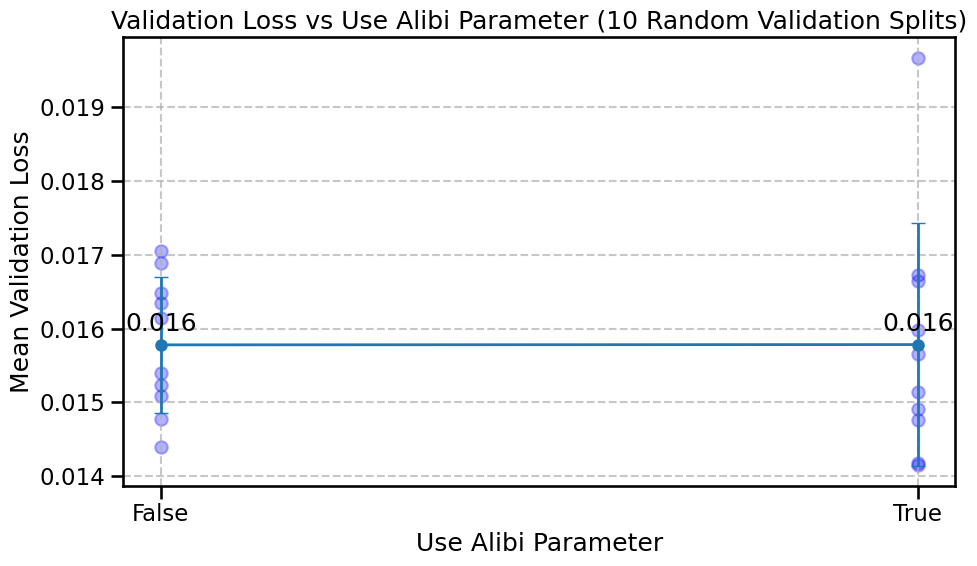

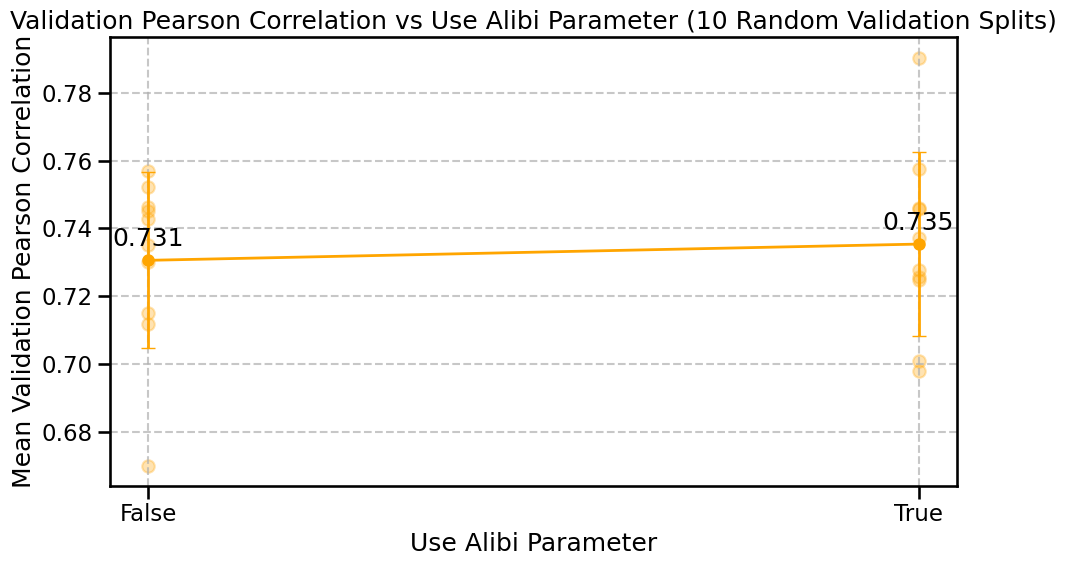

In [13]:
alibi_df.head(50)
# Drop rows where mean_val_loss is NaN
alibi_df = alibi_df.dropna(subset=['mean_val_loss'])
# Sort the dataframe by use_alibi column
alibi_df = alibi_df.sort_values(by='use_alibi')

alibi_df.head(50)

# Group by use_alibi and calculate mean and std of mean_val_loss
alibi_stats = alibi_df.groupby('use_alibi')['mean_val_loss'].agg(['mean', 'std']).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))

# Add scatter plot of all points
for i, use_alibi in enumerate(alibi_stats['use_alibi']):
    points = alibi_df[alibi_df['use_alibi'] == use_alibi]['mean_val_loss']
    plt.scatter([i] * len(points), points, alpha=0.3, color='blue')

plt.errorbar(range(len(alibi_stats)), 
            alibi_stats['mean'], 
            yerr=alibi_stats['std'],
            fmt='o-',  # Line style with points
            capsize=5,  # Cap width for error bars
            markersize=8,  # Size of points
            linewidth=2)  # Width of line

plt.xlabel('Use Alibi Parameter')
plt.ylabel('Mean Validation Loss')
plt.title('Validation Loss vs Use Alibi Parameter (10 Random Validation Splits)')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-ticks to show use_alibi values
plt.xticks(range(len(alibi_stats)), alibi_stats['use_alibi'])

# Add points to show exact values
for i, (_, y, std) in enumerate(zip(alibi_stats['use_alibi'], alibi_stats['mean'], alibi_stats['std'])):
    plt.annotate(f'{y:.3f}', 
                (i, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()

# Group by use_alibi and calculate mean and std of mean_val_pearson
alibi_pearson_stats = alibi_df.groupby('use_alibi')['mean_val_pearson'].agg(['mean', 'std']).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))

# Add scatter plot of all points
for i, use_alibi in enumerate(alibi_pearson_stats['use_alibi']):
    points = alibi_df[alibi_df['use_alibi'] == use_alibi]['mean_val_pearson']
    plt.scatter([i] * len(points), points, alpha=0.3, color='orange')

plt.errorbar(range(len(alibi_pearson_stats)), 
            alibi_pearson_stats['mean'], 
            yerr=alibi_pearson_stats['std'],
            fmt='o-',  # Line style with points
            capsize=5,  # Cap width for error bars
            markersize=8,  # Size of points
            linewidth=2,
            color='orange')  # Width of line

plt.xlabel('Use Alibi Parameter')
plt.ylabel('Mean Validation Pearson Correlation')
plt.title('Validation Pearson Correlation vs Use Alibi Parameter (10 Random Validation Splits)')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-ticks to show use_alibi values
plt.xticks(range(len(alibi_pearson_stats)), alibi_pearson_stats['use_alibi'])

# Add points to show exact values
for i, (_, y, std) in enumerate(zip(alibi_pearson_stats['use_alibi'], alibi_pearson_stats['mean'], alibi_pearson_stats['std'])):
    plt.annotate(f'{y:.3f}', 
                (i, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()
